# Solving Grid World with Value Propagation Networks and Actor-Critic methods
This notebook is intended to recreate the main results of this project, namely a comparison between three different models
* A random agent (baseline)
* An Actor-Critic agent
* A VPN agent

We start out by defining the environment. The environment has been created from scratch and can be inspected in GridWorld.py.
The environment has multiple difficulties for agents. We will be using level 4, which entails random start position, random goal position and random walls, which means the agents have to learn how to navigate random mazes.
For simplicity, we will be working on a 5x5 grid, which still makes this a non-trivial task.

In [2]:
from GridWorld import GridWorld

# Hyperparameters
LEVEL = 4
MAP_SIZE = 5
MAP = [MAP_SIZE] * 4
WALL_PCT = 0.32

SEED = 543

env = GridWorld(map=MAP, seed=SEED, non_diag=False, rewards=(0.0, 1.0), wall_pct=WALL_PCT)

env.set_level(LEVEL)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from math import prod

## Actor-Critic
We first define our Actor-Critic model.

This model maps the input to a latent space, then uses that as input to the actor (a simple policy network) and the critic, which calculates the expected return on the given state.
The actor decides on an action through the policy network output, which is a probability distribution over the available actions.

In [4]:
class ActorCritic(nn.Module):
    """implements both actor and critic in one model"""

    def __init__(self):
        super(ActorCritic, self).__init__()
        hidden_units = 32
        hidden_units2 = 64
        self.affine1 = nn.Linear(prod(env.observation_space.shape), hidden_units)
        self.affine2 = nn.Linear(hidden_units, hidden_units2)

        # actor's layer
        self.action_head = nn.Linear(hidden_units2, env.action_space.n)

        # critic's layer
        self.value_head = nn.Linear(hidden_units2, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []
        self.saved_probabilities_of_actions = []

    def forward(self, x):
        """forward of both actor and critic"""
        x = x.flatten()
        x = torch.from_numpy(x).float()

        x = f.relu(self.affine1(x))
        x = f.relu(self.affine2(x))

        # actor: chooses action to take from state s_t
        # by returning probability of each action

        action_logits = self.action_head(x)
        action_prob = f.softmax(action_logits, dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

## Value Propagation Networks

Here we define our VPN model.

Similar to the Actor-Critic, it has an input module that maps the input into a latent space, and it has a policy network that decides on which action the agent should take. Different from the Actor-Critic is the planning module. The latent space is fed to three different networks, which produce three different numbers for each state in the grid, the expected reward for entering the state $r_{in}$, the expected reward for leaving the state $r_{out}$ and the transition probabilities $p$. This is similar to the critic part of the Actor-Critic model, however, instead of evaluating a single state, it evaluates all states of the grid. These matrices, $r_{in}$, $r_{out}$ and $p$ are then fed to the **planning** module, which is the major difference between the two models. The planning module is a simple convolution run for a set number of iterations (here 5). It iterates according to the following formula:
\begin{align}
    v^{(0)}(s) &= 0,\\
    v^{(k)}(s) &= \max_{s_i\in\mathcal{N}(s)}\left(v^{(k-1)}(s_i)p(s_i)+r_{in}(s_i)-r_{out}(s_i)\right)
\end{align}

In order to not narrow the output matrix, the input matrices are zero-padded.

The output of the planning module is then fed to the policy network, along with the environment to select an action.

In [5]:
K = 5 # Number of planning iterations

class VPN(nn.Module):
    def __init__(self):
        super(VPN, self).__init__()
        hidden_units = 32
        hidden_units2 = 64
        hidden_units_policy1 = 32

        self.n_observation1 = env.observation_space.shape[1]
        self.n_observation2 = env.observation_space.shape[2]
        n_state_dims = self.n_observation1 * self.n_observation2
        n_actions = len(env.DIRS)

        # Maps input to latent space
        self.affine1 = nn.Linear(prod(env.observation_space.shape), hidden_units)
        self.affine2 = nn.Linear(hidden_units, hidden_units2)

        # r_out's head
        self.r_out = nn.Linear(hidden_units2, n_state_dims)

        # r_in's head
        self.r_in = nn.Linear(hidden_units2, n_state_dims)

        # Transition probability head
        self.p = nn.Linear(hidden_units2, n_state_dims)

        # Policy network
        self.policyNetwork1 = nn.Linear(n_state_dims * 4, hidden_units_policy1)

        self.policyHead = nn.Linear(hidden_units_policy1, n_actions)

        # action & reward buffer
        self.saved_actions = []
        self.saved_probabilities_of_actions = []
        self.rewards = []
        self.shape_of_board = (env.observation_space.shape[1], env.observation_space.shape[2])
        self.v_current = torch.zeros(self.shape_of_board)
        self.v_next = torch.zeros(self.shape_of_board)

    def forward(self, x):
        """Assumes x to be a (3, i, j) shape, that is, our one-hot encoded environment"""
        current_position = (x[1] == 1).nonzero()
        x = x.flatten()

        x = torch.from_numpy(x).float()
        state = x
        x = f.relu(self.affine1(x))
        x = f.relu(self.affine2(x))

        r_out = torch.sigmoid(self.r_out(x))

        r_out = torch.reshape(r_out, self.shape_of_board)

        r_in = torch.sigmoid(self.r_in(x))
        r_in = torch.reshape(r_in, self.shape_of_board)

        p = torch.sigmoid(self.p(x))
        p = torch.reshape(p, self.shape_of_board)

        """value iteration"""

        # For all neighborhoods for all states, we define the value of the state, as the value of having taking the best action
        # We do this for K times
        # Notably, because we do this for all states we can get information from states infinitely long away!

        # Padding all grids with zeros
        v = f.pad(torch.zeros(self.shape_of_board), (1, 1, 1, 1))
        p = f.pad(p, (1, 1, 1, 1))
        r_in = f.pad(r_in, (1, 1, 1, 1))
        r_out = f.pad(r_out, (1, 1, 1, 1))

        for k in range(K):
            i = 0
            helper = torch.zeros((8, self.n_observation1, self.n_observation2))  # 8 directions
            for i_dot, j_dot in env.DIRS:  # For all directions (env uses 0 dim as x and 1 dim as y)

                #logic of indexing: Applied the same for v, p, r_in, r_out
                #we take the padded x, index only the "inner" v by 1:1+shape_of_board, then
                #move the "square" we index in the direction of i_dot, j_dot
                xs, xe = j_dot + 1, 1 + j_dot + self.shape_of_board[0]  # +1 because of padding
                ys, ye = i_dot + 1, 1 + i_dot + self.shape_of_board[1]

                helper[i] = v[xs:xe, ys:ye] * \
                            p[xs:xe, ys:ye] + \
                            r_in[xs:xe, ys:ye] - \
                            r_out[xs:xe, ys:ye]
                i += 1

            v = helper.max(dim=0)[0]  # max over the neighborhood
            if k < K - 1:  # don't pad if it's the last round
                v = f.pad(v, (1, 1, 1, 1))

        #policy
        input_to_policy = torch.cat((v.flatten(), state), 0)
        action_logits = f.relu(self.policyNetwork1(input_to_policy))
        action_logits = self.policyHead(action_logits)
        action_prob = f.softmax(action_logits, dim=-1)

        #value at current state

        state_value = v[current_position]

        return action_prob, state_value

Our training loop has been broken into multiple tasks. The content of the loop is
1. Resetting the environment to the given level.
2. Repeatedly selecting an action using the given model until the environment has been solved or the `GIVE_UP` limit has been reached.
3. Finishing the episode by calculating the losses and backpropagating through them.
4. If the episode is a multiple of `LOG_INTERVAL`, the model will be tested for win rates on newly reset environments.

In [6]:
import torch.optim as optim

# Hyperparameters
LEARNING_RATE = 0.001

MODELS = [ActorCritic, VPN]
MODEL_NAMES = ["AC", "VPN"]

PATH = ""
START_TIME = 0
MODEL = ActorCritic()
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

In [7]:
from collections import namedtuple
from Plots import plot_agent
from torch.distributions import Categorical

import numpy as np
import time

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# Hyperparameters
GAMMA = 0.99
LOSS_COEFFICIENTS = {"value": 1, "policy": 1}
N_EPISODES = 50_000
REGULARIZATION_SCALAR = 0.002

# Settings
DO_INTERMEDIATE_TESTS = True
LOG_INTERVAL = 400
TEST_COUNT = 200


def select_action(state):
    probs, state_value = MODEL(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    MODEL.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    MODEL.saved_probabilities_of_actions.append(probs)

    # the action to take (left or right)
    return action.item()


def finish_episode():
    """Training code. Calculates actor and critic loss and performs backprop."""

    R = 0
    saved_actions = MODEL.saved_actions
    policy_losses = []  # list to save actor (policy) loss
    value_losses = []  # list to save critic (value) loss
    returns = []  # list to save the true values
    saved_probs = MODEL.saved_probabilities_of_actions
    # calculate the true value using rewards returned from the environment
    for r in MODEL.rewards[::-1]:
        # calculate the discounted value
        R = r + GAMMA * R
        returns.insert(0, R)

    returns = torch.tensor(returns)  # Cast returns to tensor

    for (log_prob, value), saved_probs, R in zip(saved_actions,saved_probs, returns):
        advantage = R - value.item()  # calculating advantage, value.item() = the state value we got

        # calculate actor (policy) loss
        entropy_regularization = torch.sum(torch.log2(saved_probs)*saved_probs)  #regularization

        policy_losses.append(-log_prob * advantage + REGULARIZATION_SCALAR*entropy_regularization)  #policy loss

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(f.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    OPTIMIZER.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum()*LOSS_COEFFICIENTS["policy"] + torch.stack(value_losses).sum()*LOSS_COEFFICIENTS["value"]

    # perform backprop

    loss.backward(retain_graph=True)   #added retain_graph=True because of regularization
    OPTIMIZER.step()
    # reset rewards and action buffer
    del MODEL.rewards[:]
    del MODEL.saved_actions[:]
    del MODEL.saved_probabilities_of_actions[:]


def train():
    test_wins = []
    ith_episode = []
    episode_rewards = []


    for i_episode in range(N_EPISODES):

        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        while True:
            action = select_action(state)
            state, reward, done = env.step(action)

            MODEL.rewards.append(reward)
            ep_reward += reward

            if done:
                break

        episode_rewards.append(ep_reward)

        # perform backprop
        finish_episode()

        # Testing for wins
        if DO_INTERMEDIATE_TESTS:
            if (i_episode + 1) % LOG_INTERVAL == 0 and i_episode > 0:
                win_ratio = test(TEST_COUNT) / TEST_COUNT
                test_wins.append(win_ratio)
                ith_episode.append(i_episode)
                minutes = (time.time() - START_TIME)/60
                time_left = round((minutes / i_episode) * (N_EPISODES - i_episode), 2)

                print(f'{(i_episode + 1) * 100 / N_EPISODES}% - {round(minutes, 2)} min ({time_left} left) - Win rate: {win_ratio}')
        if (i_episode + 1) % 100 == 0:
            print(f'Episode {i_episode + 1} - {round((time.time() - START_TIME)/60,2)} min')


    print(f'Done after {round((time.time() - START_TIME)/60, 2)} min')
    results = np.array([ith_episode, test_wins])
    plot_agent(results, TEST_COUNT)
    np.save(f'data/{PATH}', results)

def test(trials=10):
    """Return win over trials"""

    MODEL.eval()
    state = env.reset()
    wins = 0
    total = 0

    while True:
        # pick best action and take action
        action = select_action(state)
        state, r, done = env.step(action)

        if done:  # Game over
            wins += 1 if r > 0 else 0
            total += 1

            if total == trials:
                MODEL.train()
                return wins
            state = env.reset()

And to sum it all up, we can now run the code and get some results.

Episode 100 - 0.01 min
Episode 200 - 0.02 min
Episode 300 - 0.03 min
0.8% - 0.04 min (5.42 left) - Win rate: 0.14
Episode 400 - 0.04 min
Episode 500 - 0.05 min
Episode 600 - 0.06 min
Episode 700 - 0.07 min
1.6% - 0.09 min (5.33 left) - Win rate: 0.145
Episode 800 - 0.09 min
Episode 900 - 0.1 min
Episode 1000 - 0.11 min
Episode 1100 - 0.11 min
2.4% - 0.13 min (5.39 left) - Win rate: 0.145
Episode 1200 - 0.13 min
Episode 1300 - 0.14 min
Episode 1400 - 0.15 min
Episode 1500 - 0.16 min
3.2% - 0.17 min (5.29 left) - Win rate: 0.11
Episode 1600 - 0.17 min
Episode 1700 - 0.18 min
Episode 1800 - 0.19 min
Episode 1900 - 0.2 min
4.0% - 0.22 min (5.21 left) - Win rate: 0.13
Episode 2000 - 0.22 min
Episode 2100 - 0.23 min
Episode 2200 - 0.23 min
Episode 2300 - 0.24 min
4.8% - 0.26 min (5.16 left) - Win rate: 0.165
Episode 2400 - 0.26 min
Episode 2500 - 0.27 min
Episode 2600 - 0.28 min
Episode 2700 - 0.29 min
5.6% - 0.3 min (5.11 left) - Win rate: 0.155
Episode 2800 - 0.3 min
Episode 2900 - 0.31 mi

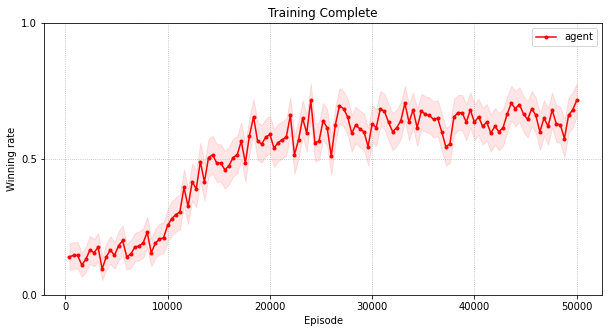

In [8]:
# AC Training
PATH = f"{MODEL_NAMES[0]}_{LEVEL}_{N_EPISODES}"
START_TIME = time.time()
MODEL = MODELS[0]()
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

train()
torch.save(MODEL, f"agents/{PATH}")

Episode 100 - 0.08 min
Episode 200 - 0.16 min
Episode 300 - 0.23 min
0.8% - 0.38 min (47.72 left) - Win rate: 0.105
Episode 400 - 0.38 min
Episode 500 - 0.46 min
Episode 600 - 0.54 min
Episode 700 - 0.62 min
1.6% - 0.76 min (46.88 left) - Win rate: 0.115
Episode 800 - 0.76 min
Episode 900 - 0.87 min
Episode 1000 - 0.96 min
Episode 1100 - 1.05 min
2.4% - 1.2 min (48.71 left) - Win rate: 0.115
Episode 1200 - 1.2 min
Episode 1300 - 1.28 min
Episode 1400 - 1.37 min
Episode 1500 - 1.45 min
3.2% - 1.59 min (48.01 left) - Win rate: 0.155
Episode 1600 - 1.59 min
Episode 1700 - 1.67 min
Episode 1800 - 1.75 min
Episode 1900 - 1.83 min
4.0% - 1.98 min (47.54 left) - Win rate: 0.135
Episode 2000 - 1.98 min
Episode 2100 - 2.07 min
Episode 2200 - 2.15 min
Episode 2300 - 2.24 min
4.8% - 2.39 min (47.4 left) - Win rate: 0.105
Episode 2400 - 2.39 min
Episode 2500 - 2.47 min
Episode 2600 - 2.55 min
Episode 2700 - 2.63 min
5.6% - 2.78 min (46.8 left) - Win rate: 0.14
Episode 2800 - 2.78 min
Episode 2900 

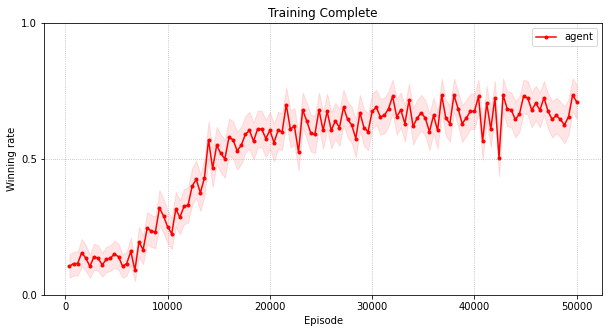

In [9]:
# VPN Training
PATH = f"{MODEL_NAMES[1]}_{LEVEL}_{N_EPISODES}"
START_TIME = time.time()
MODEL = MODELS[1]()
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

train()
torch.save(MODEL, f"agents/{PATH}")